# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

# Read in CSV

In [2]:
flights = pd.read_csv('LAXDeparturesNonstop.csv')

We will take a look at the dataframe...

In [3]:
flights.head(10)

,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,2022-04-16,2022-04-17,LAX,ATL,KNR,PT4H4M,1,False,False,True,272.00,328.59,0,NaN,2022-04-17T22:50:00.000-07:00,2022-04-18T05:54:00.000-04:00,ATL,LAX,Spirit Airlines,NK,AIRBUS INDUSTRIE A320 SHARKLETS,14640,None,coach
1,2022-04-16,2022-04-17,LAX,ATL,KNR,PT4H7M,1,False,False,True,272.00,328.59,0,NaN,2022-04-17T17:20:00.000-07:00,2022-04-18T00:27:00.000-04:00,ATL,LAX,Spirit Airlines,NK,AIRBUS INDUSTRIE A320 SHARKLETS,14820,None,coach
2,2022-04-16,2022-04-17,LAX,ATL,HA0QA0MQ,PT3H56M,0,False,False,True,450.23,498.60,8,1919.0,2022-04-17T07:00:00.000-07:00,2022-04-17T13:56:00.000-04:00,ATL,ONT,Delta,DL,Airbus A321,14160,1919,coach
3,2022-04-16,2022-04-17,LAX,ATL,HA0QA0MQ,PT3H57M,0,False,False,True,450.23,498.60,9,1919.0,2022-04-17T13:00:00.000-07:00,2022-04-17T19:57:00.000-04:00,ATL,ONT,Delta,DL,Airbus A321,14220,1919,coach
4,2022-04-16,2022-04-17,LAX,ATL,HA0QA0MQ,PT3H59M,1,False,False,True,450.23,498.60,9,1919.0,2022-04-17T22:35:00.000-07:00,2022-04-18T05:34:00.000-04:00,ATL,ONT,Delta,DL,Airbus A321,14340,1919,coach
5,2022-04-16,2022-04-17,LAX,ATL,MA0QA0MQ,PT4H8M,0,False,False,True,543.26,598.61,9,1943.0,2022-04-17T06:00:00.000-07:00,2022-04-17T13:08:00.000-04:00,ATL,LAX,Delta,DL,Airbus A321,14880,1943,coach
6,2022-04-16,2022-04-17,LAX,ATL,MA0QA0MQ,PT4H9M,0,False,False,True,543.26,598.61,7,1943.0,2022-04-17T07:15:00.000-07:00,2022-04-17T14:24:00.000-04:00,ATL,LAX,Delta,DL,Airbus A321,14940,1943,coach
7,2022-04-16,2022-04-17,LAX,ATL,MA0QA0MQ,PT4H9M,1,False,False,True,543.26,598.61,9,1943.0,2022-04-17T22:20:00.000-07:00,2022-04-18T05:29:00.000-04:00,ATL,LAX,Delta,DL,Boeing 757-300,14940,1943,coach
8,2022-04-16,2022-04-17,LAX,ATL,MA0QA0MQ,PT4H10M,0,False,False,True,543.26,598.61,9,1943.0,2022-04-17T14:55:00.000-07:00,2022-04-17T22:05:00.000-04:00,ATL,LAX,Delta,DL,Boeing 757-200,15000,1943,coach
9,2022-04-16,2022-04-17,LAX,ATL,MA0QA0MQ,PT4H11M,1,False,False,True,543.26,598.61,9,1943.0,2022-04-17T17:30:00.000-07:00,2022-04-18T00:41:00.000-04:00,ATL,LAX,Delta,DL,Airbus A321,15060,1943,coach


# Data Cleaning

## Missing Values

There might be some null values we have to fill so we will check...

In [4]:
flights.isna().any()

searchDate                      False
flightDate                      False
startingAirport                 False
destinationAirport              False
fareBasisCode                   False
travelDuration                  False
elapsedDays                     False
isBasicEconomy                  False
isRefundable                    False
isNonStop                       False
baseFare                        False
totalFare                       False
seatsRemaining                  False
totalTravelDistance              True
segmentsDepartureTimeRaw        False
segmentsArrivalTimeRaw          False
segmentsArrivalAirportCode      False
segmentsDepartureAirportCode    False
segmentsAirlineName             False
segmentsAirlineCode             False
segmentsEquipmentDescription     True
segmentsDurationInSeconds       False
segmentsDistance                False
segmentsCabinCode               False
dtype: bool

We see that *totalTravelDistance* and *segmentsEquipmentDescription* have null values...

In [5]:
print(f"totalTravelDistance has {flights['totalTravelDistance'].isna().sum()} null values")
print(f"segmentsEquipmentDescription has {flights['segmentsEquipmentDescription'].isna().sum()} null values")

totalTravelDistance has 125386 null values
segmentsEquipmentDescription has 295990 null values


In [6]:
#fills the missing totalTravelDistance column with the average distance to that airport
def fillVals(df):
    flightDistDict = df.groupby(['destinationAirport'])['totalTravelDistance'].mean()
    flightDistDict.update({'LGA':'2469'})
    df['totalTravelDistance']=df['totalTravelDistance'].fillna(df['destinationAirport'].map(flightDistDict))
    return df

flights = fillVals(flights)

We will drop *segmentsEquipmentDescription* since there is a lot of null values and we assume that the type of aircraft will not be significant in the prediction of fare prices

In [7]:
flights = flights.drop('segmentsEquipmentDescription',axis=1)

We check if there are any null values after

In [8]:
flights.isna().any().sum()

0

# EDA

We then define helper functions to help us preprocess and clean the data

In [9]:

def extractMonth(date):
    month = date.strftime("%m")
    return month

def extractDay(date):
    day = date.strftime("%d")
    return day

def timeToMinutes(s):
    if('DT' in s):
        if('H' in s):
            hours = int(''.join(filter(str.isdigit, s.split('DT')[1].split('H')[0])))
            if('M' in s):
                minutes = int(''.join(filter(str.isdigit, s.split('H')[1])))
                return 3600+hours*60+ minutes
            else:
                return 3600+hours*60
        else:
            minutes= int(''.join(filter(str.isdigit, s.split('DT')[1])))
            return 3600+ minutes
    elif('M' in s):
        hours = int(''.join(filter(str.isdigit, s.split('H')[0])))
        minutes = int(''.join(filter(str.isdigit, s.split('H')[1])))
        return (hours*60)+minutes
    else:
        hours = int(''.join(filter(str.isdigit, s.split('H')[0])))
        return (hours*60)
    

def time_of_day(s):
        hour, minute = map(int, s.split(":"))
        if hour < 12:
            return "morning"
        elif hour < 17:
            return "afternoon"
        else:
            return "evening"
    
    

def toDepartTime(s):
    return re.findall(r'\d{2}:\d{2}', s)[0]


def toArriveTime(s):
    try:
        return re.findall(r'\d{2}:\d{2}', s)[2]
    except:
        return re.findall(r'\d{2}:\d{2}', s)[0]

def toAirline(string):
    s = set(string.split("||"))
    for i in s:
        return i
    
def extractHour(s):
    return s.split(":")[0]

def extractMin(s):
    return s.split(":")[1]

In [10]:
def cleanDF(flights):
    #flights['flightTimeInMinutes'] = flights['travelDuration'].apply(timeToMinutes)
    flights = flights.rename(columns={"segmentsCabinCode": "class"})
    flights['departureTime']=flights['segmentsDepartureTimeRaw'].apply(toDepartTime)
    flights['arrivalTime']=flights['segmentsArrivalTimeRaw'].apply(toArriveTime)
    flights['timeOfDayDepart']=flights['departureTime'].apply(time_of_day)
    flights['timeOfDayArrive']=flights['arrivalTime'].apply(time_of_day)
    flights['airline'] = flights['segmentsAirlineName'].apply(toAirline)
    flights['searchDate'] = pd.to_datetime(flights['searchDate'])
    flights['flightDate'] = pd.to_datetime(flights['flightDate'])
    flights['flightMonth'] = flights['flightDate'].apply(extractMonth)
    flights['flightDay'] = flights['flightDate'].apply(extractDay)
    flights['date_difference'] = (flights['flightDate'] - flights['searchDate']).dt.days.astype(int)
    flights['arrivalHour'] = flights['arrivalTime'].apply(extractHour)
    flights['arrivalMinute'] = flights['arrivalTime'].apply(extractMin)
    flights['departureHour'] = flights['departureTime'].apply(extractHour)
    flights['departureMinute'] = flights['departureTime'].apply(extractMin)
    flights = flights.drop(['travelDuration','segmentsDepartureTimeRaw','segmentsArrivalTimeRaw','arrivalTime',
                            'departureTime','searchDate','flightDate','startingAirport','segmentsAirlineName',
                            'fareBasisCode','elapsedDays','isRefundable','isNonStop','baseFare','segmentsArrivalAirportCode',
                            'segmentsDepartureAirportCode','segmentsAirlineName','segmentsAirlineCode','segmentsDistance'],axis=1)
    return flights



In [11]:
#cleaning our dataset
flights_cleaned = cleanDF(flights)
flights_cleaned.head(10)

,destinationAirport,isBasicEconomy,totalFare,seatsRemaining,totalTravelDistance,segmentsDurationInSeconds,class,timeOfDayDepart,timeOfDayArrive,airline,flightMonth,flightDay,date_difference,arrivalHour,arrivalMinute,departureHour,departureMinute
0,ATL,False,328.59,0,1935.904522,14640,coach,evening,morning,Spirit Airlines,04,17,1,05,54,22,50
1,ATL,False,328.59,0,1935.904522,14820,coach,evening,morning,Spirit Airlines,04,17,1,00,27,17,20
2,ATL,False,498.60,8,1919.0,14160,coach,morning,afternoon,Delta,04,17,1,13,56,07,00
3,ATL,False,498.60,9,1919.0,14220,coach,afternoon,evening,Delta,04,17,1,19,57,13,00
4,ATL,False,498.60,9,1919.0,14340,coach,evening,morning,Delta,04,17,1,05,34,22,35
5,ATL,False,598.61,9,1943.0,14880,coach,morning,afternoon,Delta,04,17,1,13,08,06,00
6,ATL,False,598.61,7,1943.0,14940,coach,morning,afternoon,Delta,04,17,1,14,24,07,15
7,ATL,False,598.61,9,1943.0,14940,coach,evening,morning,Delta,04,17,1,05,29,22,20
8,ATL,False,598.61,9,1943.0,15000,coach,afternoon,evening,Delta,04,17,1,22,05,14,55
9,ATL,False,598.61,9,1943.0,15060,coach,evening,morning,Delta,04,17,1,00,41,17,30


In [12]:
flights['segmentsDistance'].isna().sum()

0

In [13]:
plt.figure(figsize=(15,12))
corr = flights.corr()
corr.style.background_gradient(cmap='RdBu_r')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

/Users/toeknee/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/toeknee/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,segmentsDurationInSeconds
elapsedDays,1.000000,-0.019557,nan,nan,0.108250,0.108192,0.057078,0.287705
isBasicEconomy,-0.019557,1.000000,nan,nan,-0.275062,-0.279994,0.275974,-0.194303
isRefundable,nan,nan,nan,nan,nan,nan,nan,nan
isNonStop,nan,nan,nan,nan,nan,nan,nan,nan
baseFare,0.108250,-0.275062,nan,nan,1.000000,0.999422,0.081375,0.502913
totalFare,0.108192,-0.279994,nan,nan,0.999422,1.000000,0.062483,0.505019
seatsRemaining,0.057078,0.275974,nan,nan,0.081375,0.062483,1.000000,0.034053
segmentsDurationInSeconds,0.287705,-0.194303,nan,nan,0.502913,0.505019,0.034053,1.000000


<Figure size 1080x864 with 0 Axes>

## Encoding Categorical Data

We will now encode the categorical data by the following:
* **nomial**: destinationAirport, airline (**one hot encoding**)
* **ordinal**: class, timeOfDayDepart, timeOfDayArrive (**label encoding**)

In [14]:
Destination = flights[['destinationAirport']]
Destination = pd.get_dummies(Destination)
Destination.head(100)

,destinationAirport_ATL,destinationAirport_BOS,destinationAirport_CLT,destinationAirport_DEN,destinationAirport_DFW,destinationAirport_DTW,destinationAirport_EWR,destinationAirport_IAD,destinationAirport_JFK,destinationAirport_LGA,destinationAirport_MIA,destinationAirport_OAK,destinationAirport_ORD,destinationAirport_PHL,destinationAirport_SFO
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [15]:
Airline = flights_cleaned[['airline']]
Airline = pd.get_dummies(Airline)
Airline

,airline_Alaska Airlines,airline_American Airlines,airline_Delta,airline_Frontier Airlines,airline_JetBlue Airways,airline_Spirit Airlines,airline_United
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
1917111,0,0,0,0,0,0,1
1917112,0,1,0,0,0,0,0
1917113,0,0,0,0,0,0,1
1917114,1,0,0,0,0,0,0


In [16]:
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
flights_cleaned['timeOfDayArrive_label']= labelencoder.fit_transform(flights_cleaned['timeOfDayArrive'])
flights_cleaned['timeOfDayDepart_label']= labelencoder.fit_transform(flights_cleaned['timeOfDayDepart'])
flights_cleaned['class_label']= labelencoder.fit_transform(flights_cleaned['class'])

In [17]:
flights_model = pd.concat([flights_cleaned,Destination,Airline],axis=1)
flights_model = flights_model.drop(['destinationAirport','airline','timeOfDayArrive','timeOfDayDepart','class'],axis=1)
flights_model

,isBasicEconomy,totalFare,seatsRemaining,totalTravelDistance,segmentsDurationInSeconds,flightMonth,flightDay,date_difference,arrivalHour,arrivalMinute,departureHour,departureMinute,timeOfDayArrive_label,timeOfDayDepart_label,class_label,destinationAirport_ATL,destinationAirport_BOS,destinationAirport_CLT,destinationAirport_DEN,destinationAirport_DFW,destinationAirport_DTW,destinationAirport_EWR,destinationAirport_IAD,destinationAirport_JFK,destinationAirport_LGA,destinationAirport_MIA,destinationAirport_OAK,destinationAirport_ORD,destinationAirport_PHL,destinationAirport_SFO,airline_Alaska Airlines,airline_American Airlines,airline_Delta,airline_Frontier Airlines,airline_JetBlue Airways,airline_Spirit Airlines,airline_United
0,False,328.59,0,1935.904522,14640,04,17,1,05,54,22,50,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,False,328.59,0,1935.904522,14820,04,17,1,00,27,17,20,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,False,498.60,8,1919.0,14160,04,17,1,13,56,07,00,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,498.60,9,1919.0,14220,04,17,1,19,57,13,00,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,False,498.60,9,1919.0,14340,04,17,1,05,34,22,35,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917111,False,178.60,7,339.0,5220,11,11,37,14,52,13,25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1917112,True,178.60,7,339.0,6000,11,11,37,10,18,08,38,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1917113,True,181.60,9,364.0,5340,11,11,37,15,29,14,00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1917114,False,188.60,7,339.0,4860,11,11,37,15,31,14,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


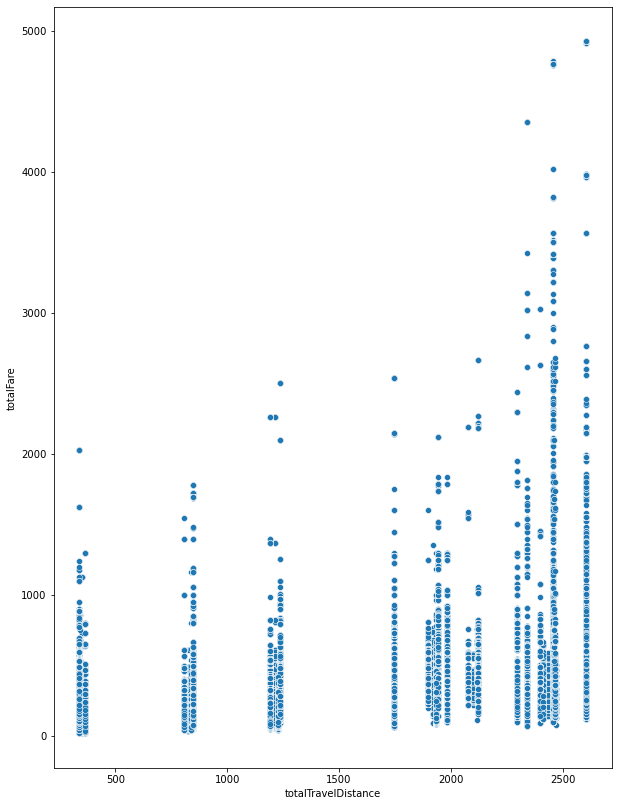

In [18]:
fig,ax = plt.subplots(figsize = (10,14))
dist_v_totalfare = sns.scatterplot(data=flights, x="totalTravelDistance", y="totalFare")

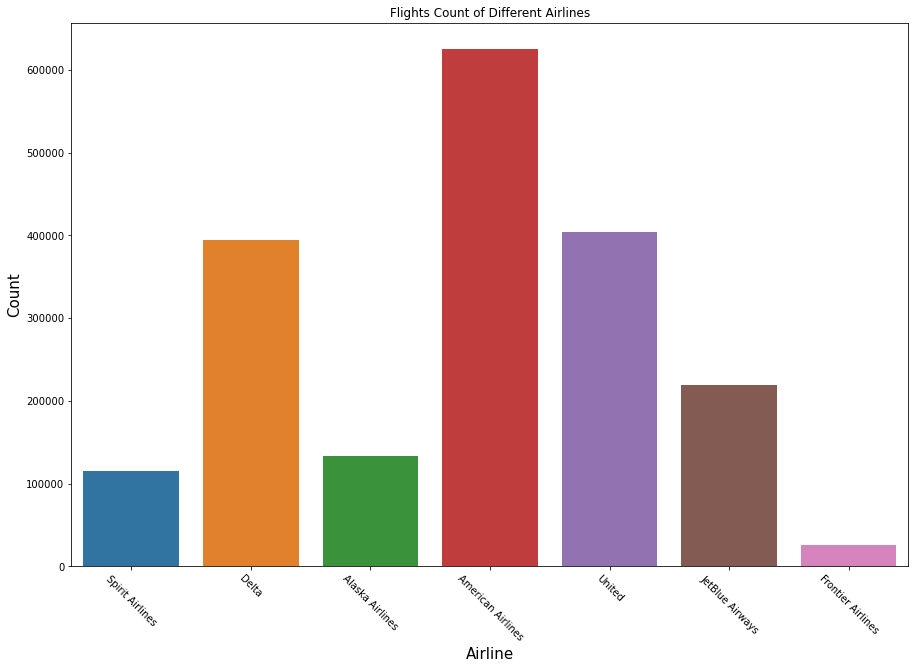

In [19]:
plt.figure(figsize=(15,10))
sns.countplot(x= flights_cleaned['airline'])
plt.title('Flights Count of Different Airlines')
plt.xlabel('Airline',fontsize=15 )
plt.xticks(rotation=-45)
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Count',fontsize=15)
plt.show()

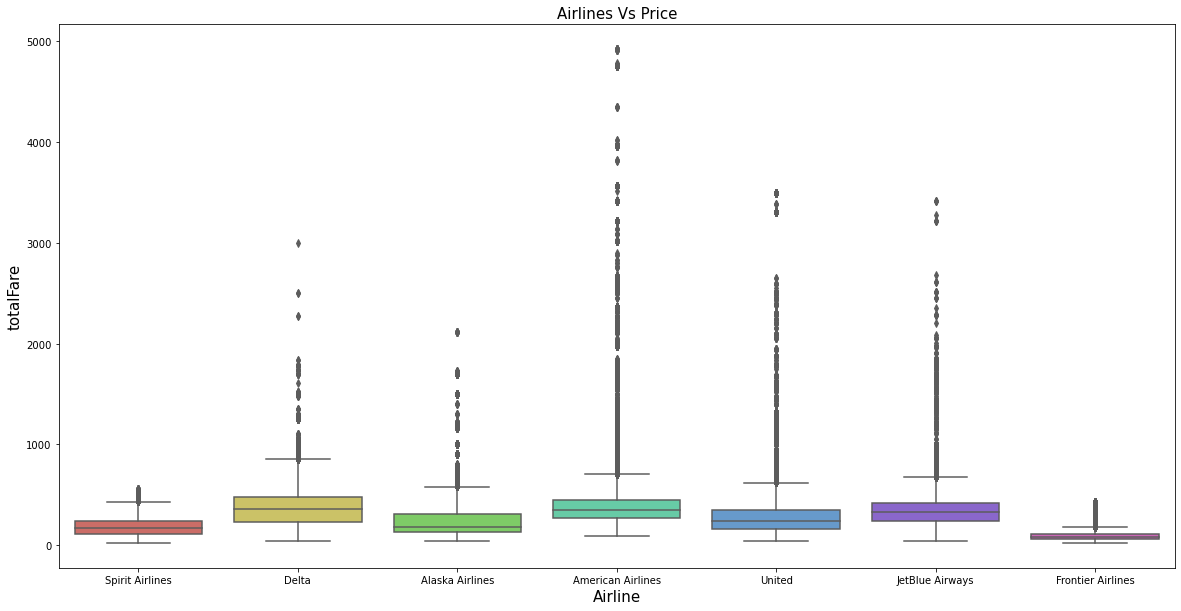

In [20]:
plt.figure(figsize=(20,10))
sns.boxplot(x=flights_cleaned['airline'],y=flights_cleaned['totalFare'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('totalFare',fontsize=15)
plt.show()

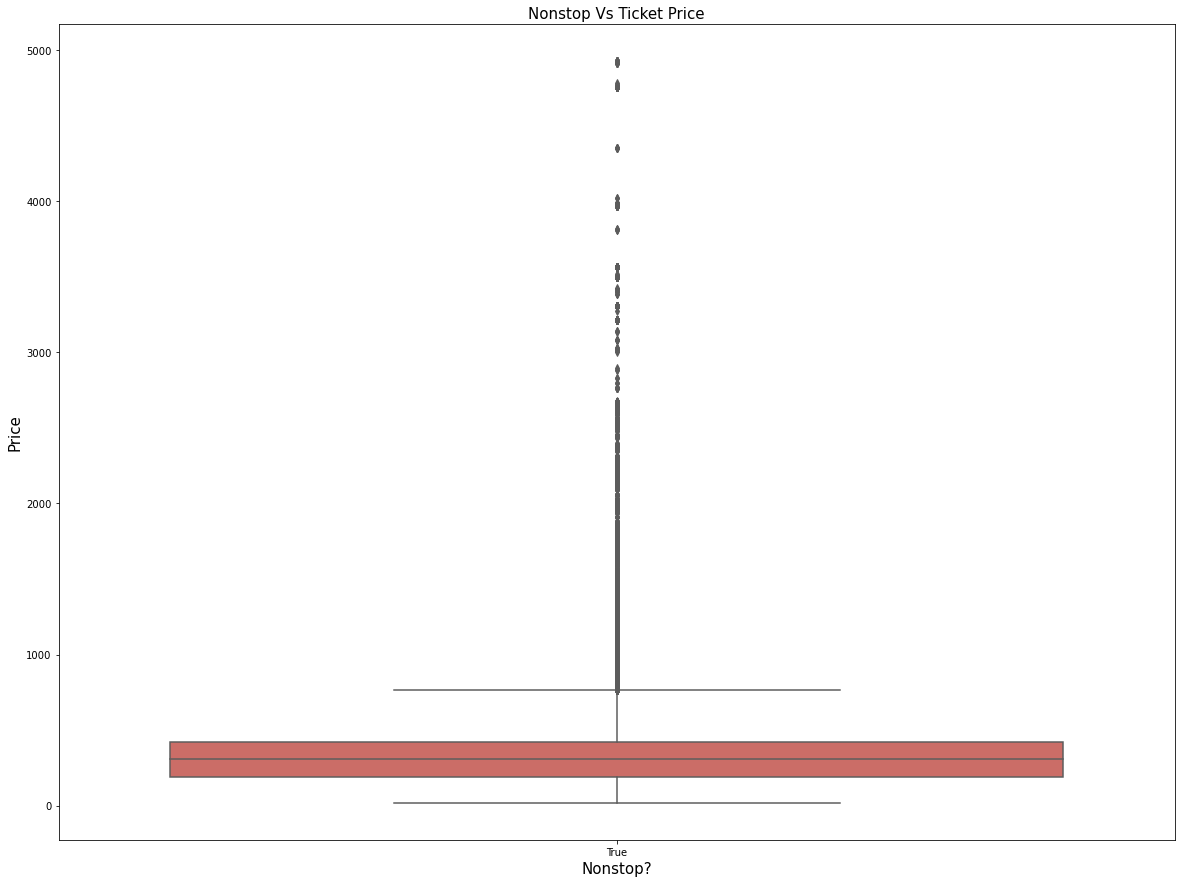

In [21]:
plt.figure(figsize=(20,15))
sns.boxplot(x='isNonStop',y='totalFare',data=flights,palette='hls')
plt.title('Nonstop Vs Ticket Price',fontsize=15)
plt.xlabel('Nonstop?',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

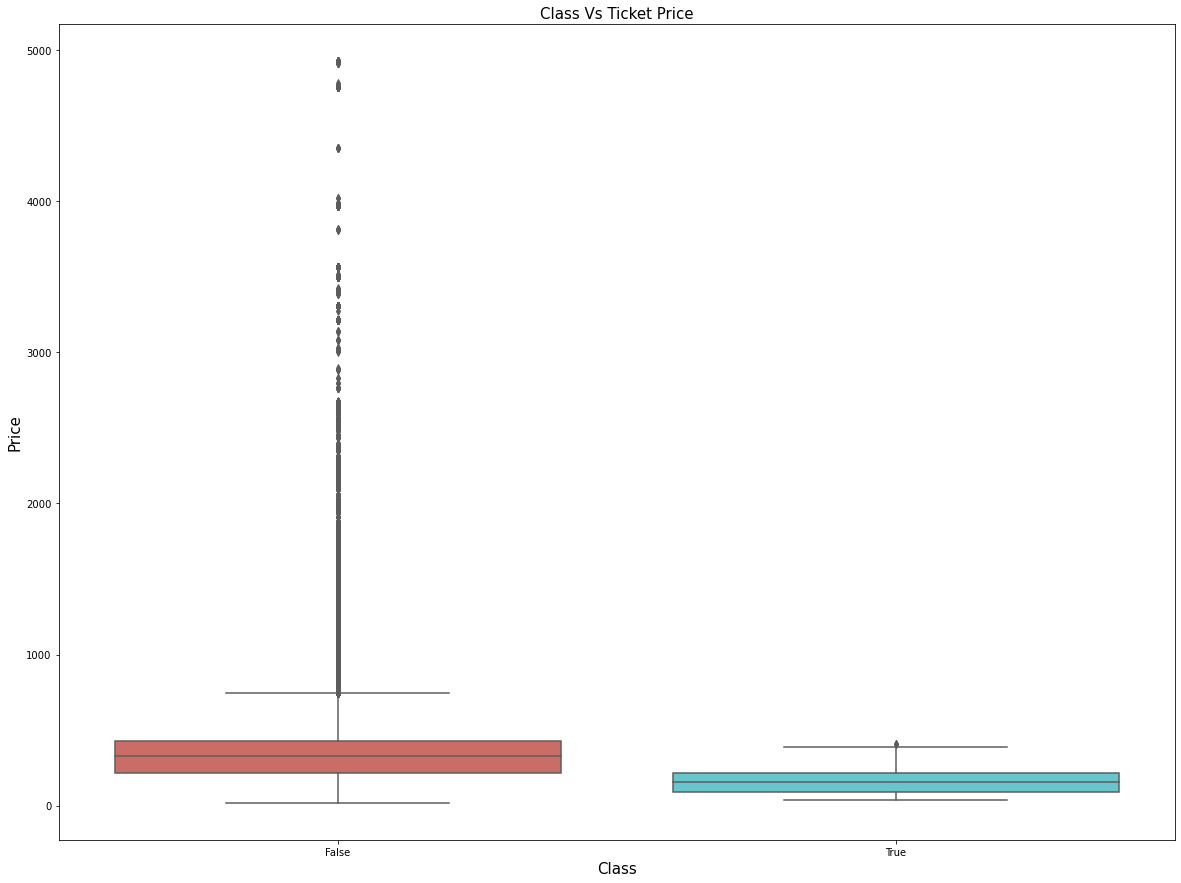

In [22]:
plt.figure(figsize=(20,15))
sns.boxplot(x='isBasicEconomy',y='totalFare',data=flights,palette='hls')
plt.title('Class Vs Ticket Price',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

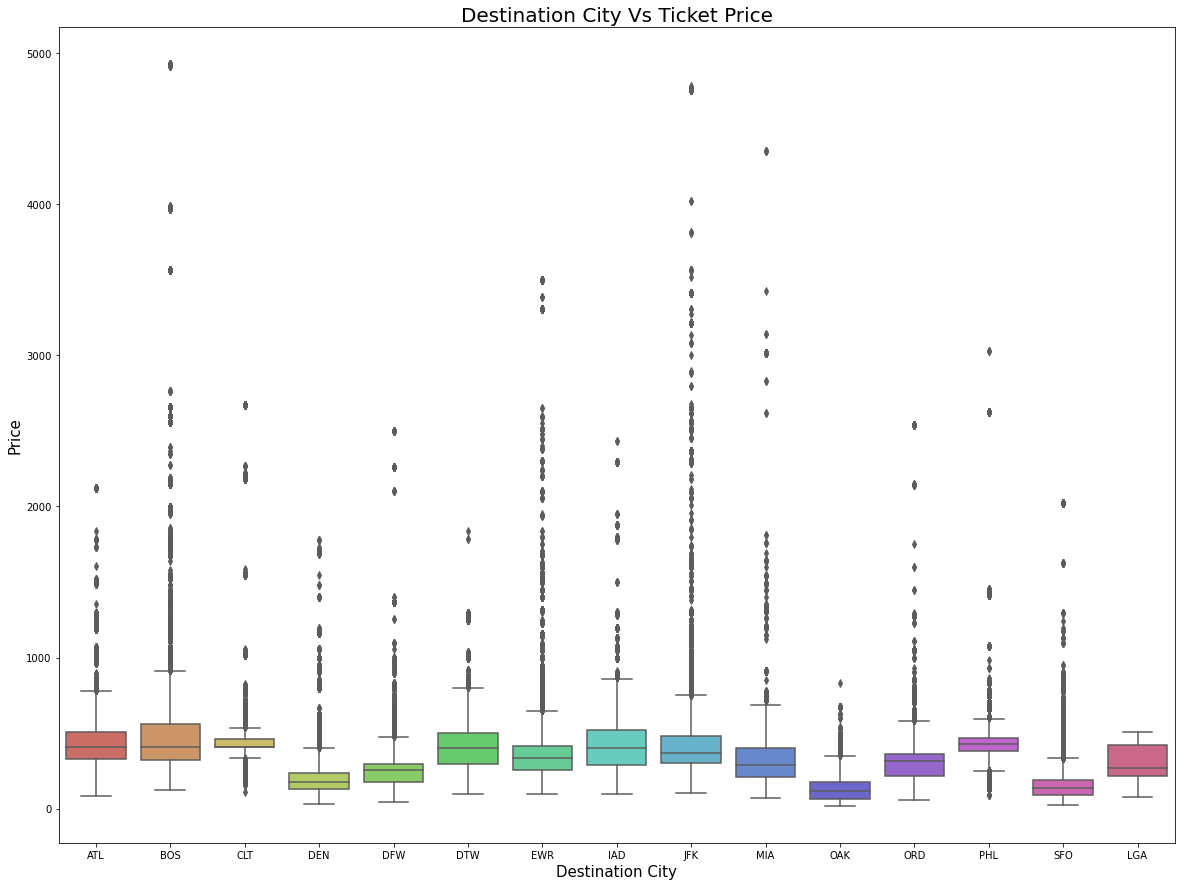

In [23]:
plt.figure(figsize=(20,15))
sns.boxplot(x='destinationAirport',y='totalFare',data=flights,palette='hls')
plt.title('Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

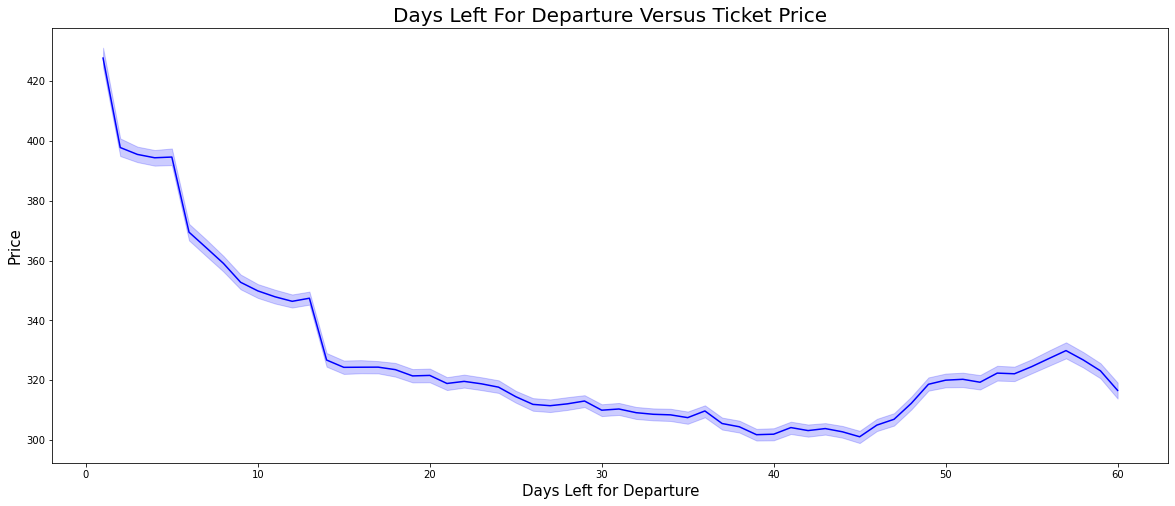

In [24]:
plt.figure(figsize=(20,8))
sns.lineplot(data=flights_cleaned,x='date_difference',y='totalFare',color='blue')
plt.title('Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

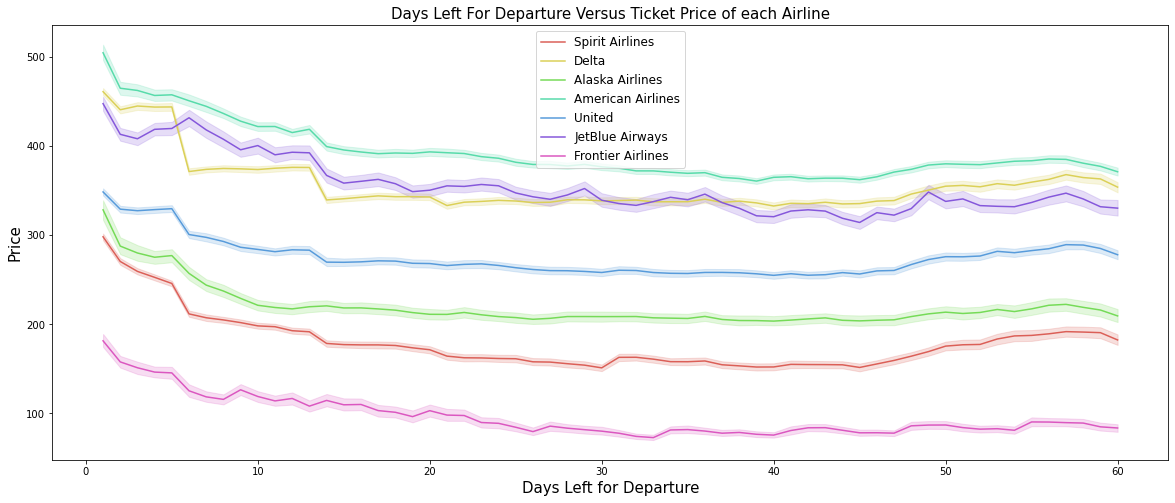

In [25]:
plt.figure(figsize=(20,8))
sns.lineplot(data=flights_cleaned,x='date_difference',y='totalFare',color='blue',hue='airline',palette='hls')
plt.title('Days Left For Departure Versus Ticket Price of each Airline',fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [26]:
flights_cleaned.groupby(['airline','destinationAirport'],as_index=False)['totalFare'].mean()

,airline,destinationAirport,totalFare
0,Alaska Airlines,ATL,438.212527
1,Alaska Airlines,DEN,246.183387
2,Alaska Airlines,DFW,193.569421
3,Alaska Airlines,EWR,327.581204
4,Alaska Airlines,IAD,427.841582
5,Alaska Airlines,SFO,138.483257
6,American Airlines,ATL,418.447694
7,American Airlines,BOS,565.034490
8,American Airlines,CLT,457.308990
9,American Airlines,DEN,235.156622


# Modeling

# Feature Selection

### heatmap

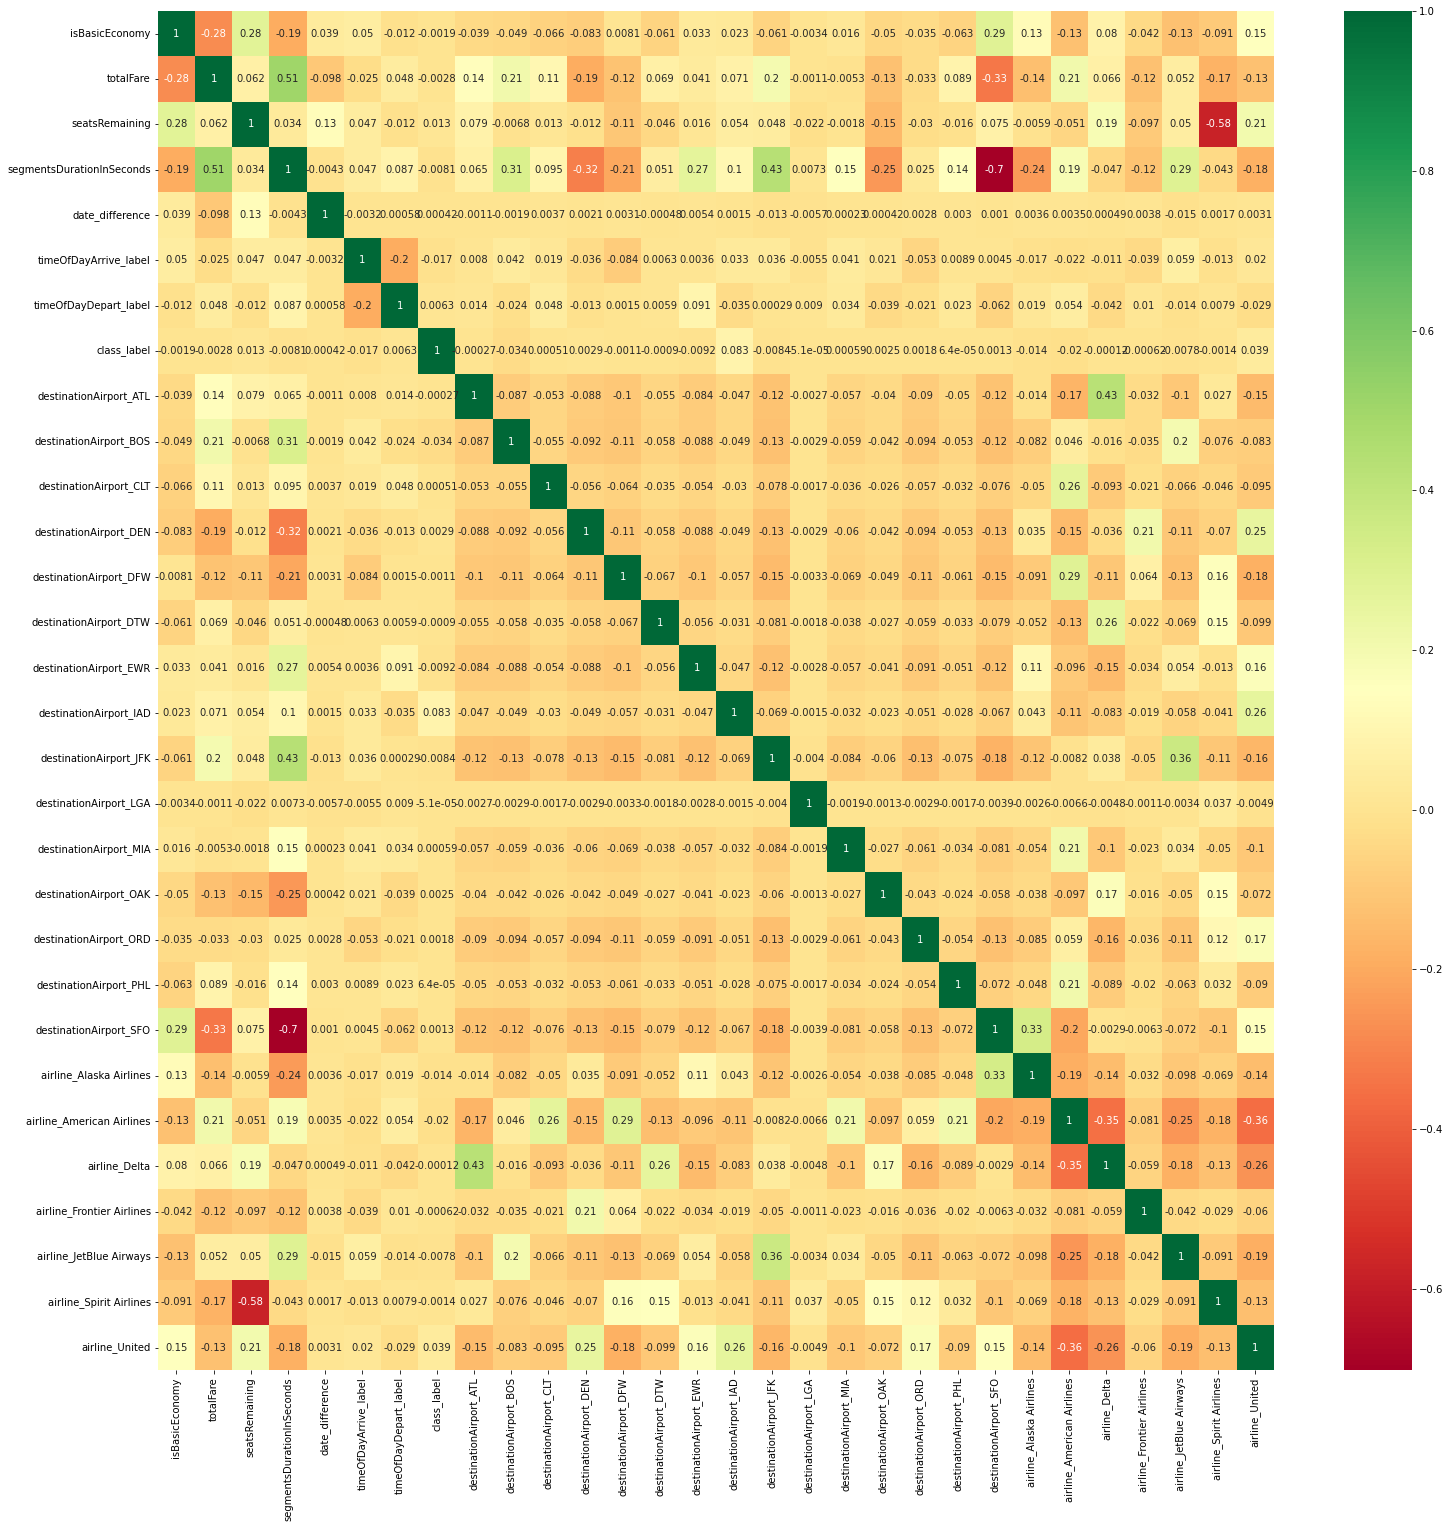

In [27]:
plt.figure(figsize = (25,25))
sns.heatmap(flights_model.corr(), annot = True, cmap = "RdYlGn")

plt.show()

Here are 2 more ways for feature selection:
* feature_importance_
* SelectKBest

## Build your model here !

### Random Forest (Test)

In [29]:
X = flights_model.drop('totalFare',axis=1)
y = flights_model['totalFare']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X[['totalTravelDistance','segmentsDurationInSeconds'] ]= scaler.fit_transform(X[['totalTravelDistance','segmentsDurationInSeconds']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [30]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)


In [31]:
reg_rf.score(X_train, y_train)


0.9905712105797101

In [32]:
reg_rf.score(X_test, y_test)


0.9332383260502588

In [36]:
from sklearn import metrics
metrics.r2_score(y_test, y_pred)

0.9332383260502588

## Saving your model

In [ ]:
# import pickle
# # open a file, where you ant to store the data
# file = open('name_of_file.pkl', 'wb')

# # dump information to that file
# pickle.dump(name_of_model, file)
# model = open('name_of_file.pkl','rb')
# someModel = pickle.load(model)

NameError: name 'name_of_model' is not defined